# BlackJack

## QAgent

## Q_Learner (choose action based on policy)

In [2]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import sys
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

env = gym.make('Blackjack-v0')
state = env.reset()
num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

class QAgent(object):
    def __init__(self, action_space,e_decay):
        self.action_space = action_space # Actions that can be taken (0 is to STAY, 1 is to HIT)
        self.actionSpaceSize = 2 # Number of actions that can be taken
        self.e_decay = e_decay
        self.episode = 0
        self.Q = defaultdict(lambda: np.array([0,0]))
        self.N = defaultdict(lambda: np.array([0,0]))
        
    
    def best_policy(self, Q, e):
        action = np.argmax(Q)
        policy = np.array([1,1])* e / self.actionSpaceSize
        policy[action] = 1 - e + (e / self.actionSpaceSize)
        return policy
    
    def Q_action(self, state , e):
        if state in self.Q:
            action = np.random.choice([0, 1], p=self.best_policy(self.Q[state], e))
        else:
            action = self.action_space.sample()
        return action

    def improve_Q_function(self, e):
        obs, acts, payouts = zip(*e)
        reduction = np.array([1.0**i for i in range(len(payouts)+1)])
        for x, ob in enumerate(obs):
            prevQ = self.Q[ob][acts[x]] 
            prevN = self.N[ob][acts[x]]
            self.Q[ob][acts[x]] = prevQ + (sum(payouts[x:]*reduction[:-(1+x)]) - prevQ)/(prevN+1)
            self.N[ob][acts[x]] += 1

    def states_in_one_episode(self, env):
        self.episode += 1
        episode = []
        epsilon = 1.0/((self.episode/self.e_decay) + 1) # epsilon decay
        observation = env.reset()
        while True:
            action = self.Q_action(observation, epsilon)
            next_obs, payout, done, _ = env.step(action)
            episode.append((observation, action, payout))
            if done:
                break
            observation = next_obs
        return episode

In [7]:
def obtain_policy_and_Q(rounds, e_decay):
    qAgent = QAgent(env.action_space, e_decay)
    for _ in range(rounds):
        episode = qAgent.states_in_one_episode(env) 
        qAgent.improve_Q_function(episode)    # update Q_value function
    p = dict((x, np.argmax(y)) for x, y in qAgent.Q.items())
    return p,qAgent.Q

def choose_action(action_space, p, obs):
    if obs not in p:
        action = action_space.sample()
    else:
        action = p[obs]
    return action


## Evaluation 

100%|██████████| 1000/1000 [00:04<00:00, 234.46it/s]


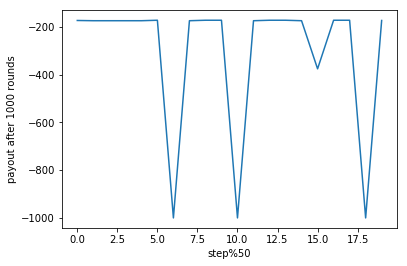

Average payout after 1000 rounds is -6.13


In [19]:
payouts = []
p, Q = obtain_policy_and_Q(1000, 800)
for sample in tqdm(range(num_samples)):
    env.seed(sample)
    obs = env.reset()
    if sample%50==0:
        round = 0
        total_payouts = 0
        while round<=num_rounds:
            action = choose_action(env.action_space, p, obs)
            next_obs, payout, done, _ = env.step(action)
            total_payouts+= payout
            if done:    
                round+=1
                env.seed(round)
                next_obs = env.reset()
        payouts.append(total_payouts)
fig = plt.figure()
plt.plot(payouts)                
plt.xlabel('step%50')
plt.ylabel('payout after 1000 rounds')
plt.show()  
print ("Average payout after {} rounds is {}".format(num_rounds, sum(payouts)/num_samples))